In [11]:
import egglib
import glob 
import pandas as pd
import numpy as np
import os
import ipyparallel as ipp
import matplotlib.pyplot as plt
import time
from scipy.stats import pearsonr

In [2]:
print(egglib.__version__)
print(ipp.__version__)

3.1.0
7.1.0


Re-run egglib whole genome pi on VCFs containing invariant sites as well, compare to previous calculations on just variant sites.

In [3]:
#save file names in chromosome order
directory='/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001_full/'
files = glob.glob(os.path.join(directory, "nlrome_invar_*_cds.recode.vcf"))
files.sort()
print(files)

['/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001_full/nlrome_invar_1_cds.recode.vcf', '/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001_full/nlrome_invar_2_cds.recode.vcf', '/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001_full/nlrome_invar_3_cds.recode.vcf', '/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001_full/nlrome_invar_4_cds.recode.vcf', '/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001_full/nlrome_invar_5_cds.recode.vcf']


In [4]:
#load the CDS VCF file 
bed=pd.read_csv('/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001_full/cds.bed', index_col=0)

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
#define a fucntion that takes the vcf path, creates a vcf object and an index, then returns the egglib vcf object 
def importer(vcf_path):
    vcf=egglib.io.VcfParser(vcf_path)
    egglib.io.make_vcf_index(vcf_path)
    vcf.load_index(vcf_path+'i')
    return vcf

#vcf1=importer(files[0])
#vcf2=importer(files[1])
#vcf3=importer(files[2])
#vcf4=importer(files[3])
#vcf5=importer(files[4])

In [6]:
#iterate through the file and see if egglib errors on any problematic lines
#only have to do this once 
def parse_check(vcf, chrom):
    vcf.goto(chrom, position=egglib.io.FIRST)
    ln=0
    for i in vcf:
        ln += 1
        try: 
            chrom, pos, nall=next(vcf)
            #print(chrom, pos, nall)
        except:
            print('error line', ln)
            print(chrom, pos)
            #next(vcf)
    return print('checked')

#print(files[0])
#parse_check(vcf1, '1')
#print(files[1])
#parse_check(vcf2, '2')
#print(files[2])
#parse_check(vcf3, '3')
#print(files[3])
#parse_check(vcf4, '4')
#print(files[4])
#parse_check(vcf5, '5')

In [7]:
#function that takes chromosome, CDS start, and CDS end, then returns an array with the vcf sites in that zone
def exon_search(bed_chrom, bed_start, bed_end, vcf):
    array=[]
    for i in vcf:
        chrom, pos, nall = next(vcf)
        if int(chrom) == bed_chrom:
            if pos >= bed_start and pos <= bed_end:
                site=vcf.get_genotypes()
                array.append(site)
            if pos > bed_end:
                break
    return array

In [8]:
#takes in CDS, harvests sites for each piece of the CDS, then calculate over it 
def combine_cds(one_gene, vcf):
    cs = egglib.stats.ComputeStats()
    cs.configure(multi_hits=True, multi=False)
    cs.add_stats('Pi', 'lseff', 'D')

    sites=[]
    cds_length=0
    for index, row in one_gene.iterrows():
        bed_chrom=int(row['chrom'])
        bed_start=int(row['bedStart'])
        bed_end=int(row['bedEnd'])
        cds_length += bed_end-bed_start
        results=exon_search(bed_chrom, bed_start, bed_end, vcf)
        sites.extend(results)

    stats=cs.process_sites(sites)
    
    lseff=stats['lseff']
    D=stats['D']
    if pd.isnull(stats['D']):
        D=np.nan
    Pi=stats['Pi']
        
    gene=one_gene.iloc[0,3]
    result={'gene':gene, 'Pi_raw':Pi, 'D':D, 'lseff':lseff, 'cds_length':cds_length}
    return result

In [9]:
#takes in chromosome integer, performs calculations, and outputs 
def wrapper(i):
    vcf=importer(files[i-1]) #import vcf file (convert to 0 integer indexing)
    genes=bed[bed['chrom']==i]['name'].unique() #filter gene list 
    bed_g=bed.groupby(['name'])
    stats=pd.DataFrame()
    vcf.goto(str(i), position=egglib.io.FIRST)
    for j in genes:
       sub=bed_g.get_group(j)
       result=combine_cds(sub, vcf)
       stats=stats.append(result, ignore_index=True)
    return stats

This is going to take a long time, and since everything is split by chromosome let's try running in parallel.

In [26]:
#first create client to interact with cluster 
my_cluster=ipp.Cluster(n=5)
c=my_cluster.start_and_connect_sync()
c.ids


Using existing profile dir: '/global/home/users/chandlersutherland/.ipython/profile_default'
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


[0, 1, 2, 3, 4]

In [33]:
#create direct view objects 
dview=c[:]
dview.block=True

['hello world', 'hello world', 'hello world', 'hello world']

In [34]:
#load necessary packages in worker processes 
dview.execute('import pandas as pd')
dview.execute('import egglib')
dview.execute('import numpy as np')

<AsyncResult: execute:finished>

In [36]:
#test vcf creation and calling within parallel 
def parallel_toy(i):
    vcf=importer(files[i-1])
    genes=bed[bed['chrom']==i]['name'].unique() #filter gene list 
    bed_g=bed.groupby(['name'])
    return bed_g

mydict=dict(files=files, bed=bed, importer=importer)
dview.push(mydict)

#%time [parallel_toy(i) for i in range(1,6)]

%time samples=dview.map_sync(parallel_toy, range(1,6))

CompositeError: one or more exceptions from call to method: parallel_toy
[0:apply]: ValueError: cannot write to index file (stream error)

In [38]:
#this chunk runs the calculation, takes forever!!
mydict=dict(bed=bed, files=files, combine_cds=combine_cds, exon_search=exon_search, importer=importer)
dview.push(mydict)
res=dview.map(wrapper, range(1,6))
res

[             D     Pi_raw  cds_length       gene   lseff
 0    -1.389381   0.322726      1284.0  AT1G01010   560.0
 1    -0.139948      1.254       729.0  AT1G01020   359.0
 2    -0.498963   0.567139      1076.0  AT1G01030   537.0
 3    -1.626366    2.32775      5710.0  AT1G01040  2835.0
 4    -0.909431  0.0366909       631.0  AT1G01050   307.0
 ...        ...        ...         ...        ...     ...
 7138 -1.518713   0.460817      1189.0  AT1G80950   588.0
 7139 -1.194592     5.9803      1455.0  AT1G80960   723.0
 7140  0.414213   0.857143       643.0  AT1G80970   319.0
 7141       NaN          0       641.0  AT1G80980   247.0
 7142  1.053901    5.92291       688.0  AT1G80990   341.0
 
 [7143 rows x 5 columns],
              D    Pi_raw  cds_length       gene   lseff
 0          NaN         0       537.0  AT2G01008    71.0
 1          NaN      None       101.0  AT2G01021     0.0
 2          NaN         0       119.0  AT2G01023     7.0
 3          NaN         0       543.0  AT2G01035

In [42]:
#concatenate dataframes and save the result 
stats=pd.concat(res)
stats['Pi_by_dna']=stats['Pi_raw']/stats['cds_length']
stats['Pi_by_lseff']=stats['Pi_raw']/stats['lseff']
stats.to_csv('/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001_full/cds_egglib_all.csv')

mean Pi/DNA:  0.0022934434169447028
median Pi/DNA:  0.001525417374090504


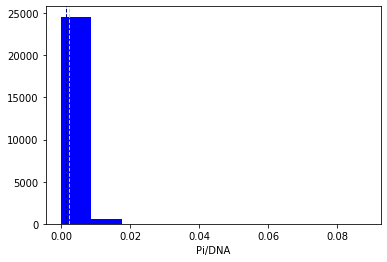

In [48]:
#start with Pi by DNA  

mean=stats['Pi_by_dna'].mean()
print('mean Pi/DNA: ', mean)
median=stats['Pi_by_dna'].median()
print('median Pi/DNA: ', median)


plt.hist(stats['Pi_by_dna'], color='blue')
plt.axvline(mean, color='lightblue', linestyle='dashed', linewidth=1)
plt.axvline(median, color='darkblue', linestyle='dashed', linewidth=1)
plt.xlabel("Pi/DNA")

plt.show()

mean Pi/lseff:  0.004679325246708553
median Pi/lseff:  0.0031119206921165956


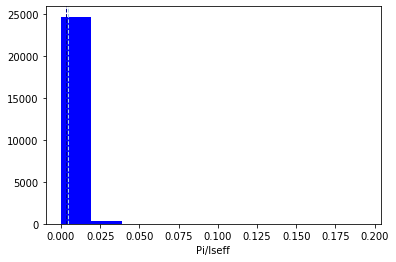

In [49]:
#start with Pi by lseff  

mean=stats['Pi_by_lseff'].mean()
print('mean Pi/lseff: ', mean)
median=stats['Pi_by_lseff'].median()
print('median Pi/lseff: ', median)


plt.hist(stats['Pi_by_lseff'], color='blue')
plt.axvline(mean, color='lightblue', linestyle='dashed', linewidth=1)
plt.axvline(median, color='darkblue', linestyle='dashed', linewidth=1)
plt.xlabel("Pi/lseff")

plt.show()

Let's compare with previous stats on the same inputs computed with just the variants present in the VCF file. 

In [50]:
#read in previous chrom1 stats 
old=pd.read_csv('/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/cds_egglib_wholegenome2.csv', index_col=0)
old

,D,Pi_raw,cds_length,gene,lseff,Pi_by_dna,Pi_by_lseff
0,0.034758,0.196163,1284.0,AT1G01010,11.0,0.000153,0.017833
1,-0.204950,0.684199,729.0,AT1G01020,7.0,0.000939,0.097743
2,-0.821854,0.442834,1076.0,AT1G01030,13.0,0.000412,0.034064
3,-1.801743,1.767348,5710.0,AT1G01040,64.0,0.000310,0.027615
4,NaN,NaN,631.0,AT1G01050,0.0,NaN,NaN
...,...,...,...,...,...,...,...
6318,NaN,NaN,246.0,AT5G67600,0.0,NaN,NaN
6319,0.499195,2.936667,1451.0,AT5G67610,26.0,0.002024,0.112949
6320,-0.251609,0.489753,546.0,AT5G67620,7.0,0.000897,0.069965
6321,-0.510494,1.038563,1408.0,AT5G67630,14.0,0.000738,0.074183


(0.9089318319004329, 0.0)


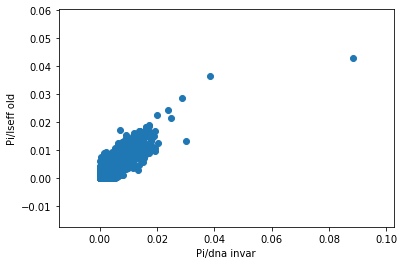

In [52]:
comp=pd.merge(stats, old, on='gene').dropna()
print(pearsonr(comp['Pi_by_dna_x'], comp['Pi_by_dna_y']))

plt.scatter(comp['Pi_by_dna_x'], comp['Pi_by_dna_y'])
plt.xlabel("Pi/dna invar")
plt.ylabel("Pi/dna old")
plt.show()

Pi/DNA scales very nicely. Glad I chose this originally but now let's see if I can switch back to Pi/site.

(0.5807978372577232, 0.0)


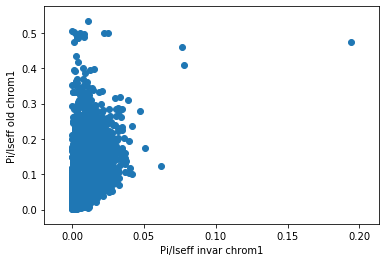

In [53]:
#comp=pd.merge(chrom1_stats, old, on='gene').dropna()
print(pearsonr(comp['Pi_by_lseff_x'], comp['Pi_by_lseff_y']))

plt.scatter(comp['Pi_by_lseff_x'], comp['Pi_by_lseff_y'])
plt.xlabel("Pi/lseff invar chrom1")
plt.ylabel("Pi/lseff old chrom1")
plt.show()

What we observed before. The Pi/lseff calculated on the variant only VCF is way overestimating values. 

(0.8295784380857876, 0.0)


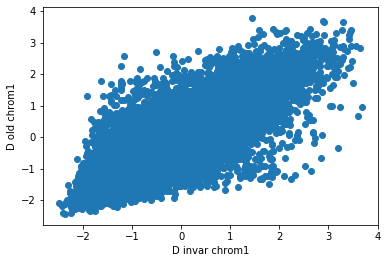

In [54]:
#comp=pd.merge(chrom1_stats, old, on='gene').dropna()
print(pearsonr(comp['D_x'], comp['D_y']))

plt.scatter(comp['D_x'], comp['D_y'])
plt.xlabel("D invar chrom1")
plt.ylabel("D old chrom1")
plt.show()

I would expect D to be a perfect r=1... but pretty good.

(0.9665210825423122, 0.0)


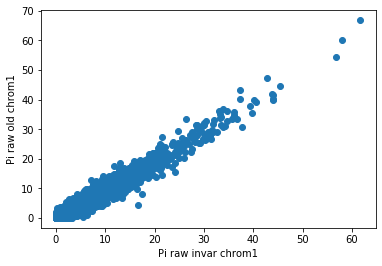

In [55]:
#comp=pd.merge(chrom1_stats, old, on='gene').dropna()
print(pearsonr(comp['Pi_raw_x'], comp['Pi_raw_y']))

plt.scatter(comp['Pi_raw_x'], comp['Pi_raw_y'])
plt.xlabel("Pi raw invar chrom1")
plt.ylabel("Pi raw old chrom1")
plt.show()

Pi raw correlation is near perfect. Therefore, the real issue here is the denominator. 